# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

# Instead of multi-task, trying to just do binary classification for 1 iMod at a time

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch
import torch.nn as nn

import random

import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score

from skorch import NeuralNetRegressor,NeuralNetClassifier,NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [3]:
set_seed(46)

Random seed set as 46


## Load data

In [4]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print("Matrix shape (ops filt):",XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

Matrix shape (ops filt): (2129, 99)


locus_tag  gene                                 product type  strand  start  \
0     b0005  yaaX  DUF2502 domain-containing protein YaaX  CDS       1   5233   
1     b0007  yaaJ               putative transporter YaaJ  CDS      -1   6528   
2     b0008  talB                         transaldolase B  CDS       1   8237   
3     b0009   mog       molybdopterin adenylyltransferase  CDS       1   9305   
4     b0010  satP        acetate/succinate:H(+) symporter  CDS      -1   9927   

                                     upstream_region         0         1  \
0  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0.008229 -0.000685   
1  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0.008111 -0.003929   
2  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0.008629 -0.001270   
3  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0.002952  0.002053   
4  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0.006142  0.000884   

          2  ...        82        83        84        85        86        87  \
0 -0.005215  ... -0.006856  0.010676  0.008874  0.018497  0.000700 -0.013267   
1  0.003207  ... -0.000337 -0.010468  0.016122  0.010361 -0.003899 -0.022839   
2 -0.005664  ...  0.000394  0.007215 -0.000707 -0.012959 -0.002329  0.006391   
3 -0.002882  ... -0.009291 -0.000226  0.016013  0.002179  0.004891 -0.002365   
4  0.008166  ... -0.009214 -0.010588  0.001363  0.003979 -0.005208  0.003190   

         88        89        90        91  
0  0.015265  0.016886 -0.015319 -0.020727  
1 -0.003665 -0.001823 -0.023604 -0.012765  
2 -0.003650 -0.008537  0.002898 -0.000891  
3 -0.003490 -0.006066 -0.011982  0.011477  
4 -0.015137 -0.005784 -0.001302  0.010800  

[5 rows x 99 columns]

TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [5]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

0  1  2  3  4  5  6  7  8  9  ...  82  83  84  85  86  87  88  89  \
locus_tag                                ...                                   
b0002      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0003      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0004      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0005      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0006      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
b4688      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4693      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4705      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

           90  91  
locus_tag          
b0002       0   0  
b0003       0   0  
b0004       0   0  
b0005       0   0  
b0006       0   0  
...        ..  ..  
b4688       0   0  
b4693       0   0  
b4696_1     0   0  
b4696_2     0   0  
b4705       0   0  

[3923 rows x 92 columns]

In [6]:
# get iModulon column labels
imods = [x.strip() for x in Mb.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [7]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  82  83  84  85  86  87  88  89  90  91  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 99 columns]

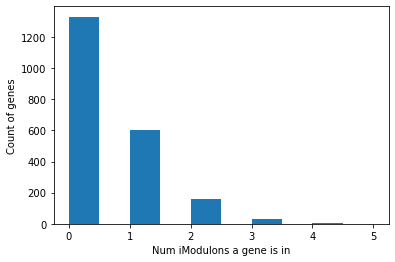

In [8]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Get the most populated iModulons
I don't know which iMods are most likely to work, so let's start with a few that have a lot of members

In [9]:
# make a sorted list of imodulons by their member count
XYim = XYb[imods]
mbc = sorted([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])],key=lambda x:x[1],reverse=True)

n = 10
topn = mbc[:n]

topn

[('82', 82),
 ('50', 61),
 ('25', 48),
 ('84', 47),
 ('21', 42),
 ('38', 37),
 ('58', 33),
 ('40', 31),
 ('48', 28),
 ('69', 27)]

<BarContainer object of 92 artists>

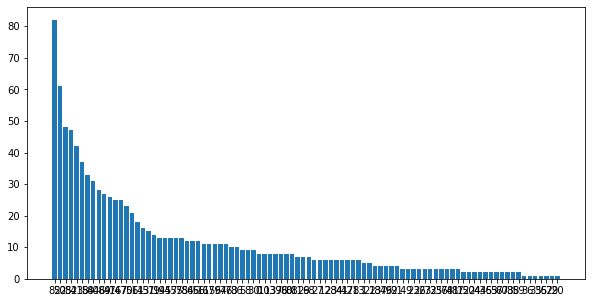

In [10]:
figure = plt.figure(figsize=(10,5))
x,y = [list(x) for x in zip(*mbc)]
plt.bar(x,y)


In [43]:
# SET NUMBER OF IMODS HERE

imod = [mbc[0][0]]
imod = [mbc[0][0],mbc[1][0],mbc[2][0],]
print(f'Investigating iMod {imod}')

#X, y = tu.make_st_skorch_dfs(XYb, seq_col="upstream_region",target_col=imod)
X, y = tu.make_mt_skorch_dfs(XYb, seq_col="upstream_region",target_cols=imod)
print("\nX:",X.shape)
print("y:",y.shape)

Investigating iMod ['82', '50', '25']

X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 3])


In [48]:
y[:,3]

IndexError: index 3 is out of bounds for dimension 1 with size 3

In [12]:
from skmultilearn.model_selection import iterative_train_test_split

def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

In [13]:
Xfull_train_strat, yfull_train_strat, Xtest_strat, ytest_strat = iterative_train_test_split(X, y, test_size = 0.2)
Xtrain_strat, ytrain_strat, Xval_strat, yval_strat = iterative_train_test_split(Xfull_train_strat, yfull_train_strat, test_size = 0.2)


In [14]:
yfull_train_strat

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

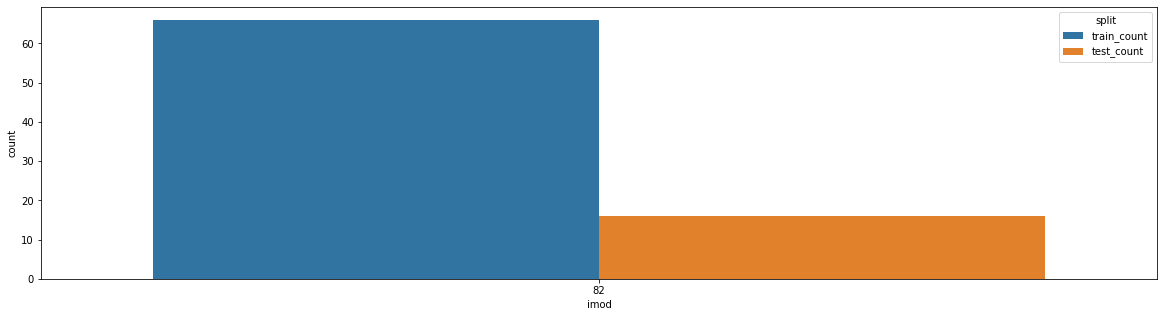

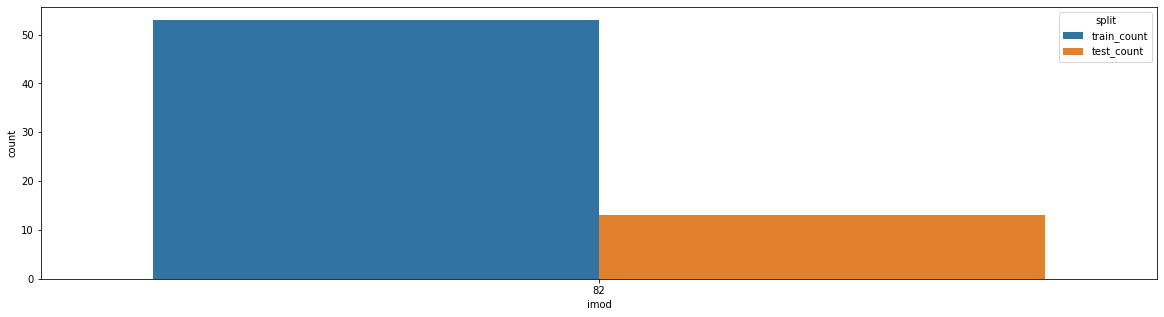

In [15]:
count_imod_train_test_labels(imod,yfull_train_strat,ytest_strat)
count_imod_train_test_labels(imod,ytrain_strat,yval_strat)

## pick some params

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [17]:
y.shape

torch.Size([2129, 1])

In [18]:
from skorch.dataset import ValidSplit

In [19]:
# class DNA_2CNN_2FC_Multi(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  n_tasks,
#                  num_filters1=32,
#                  num_filters2=32,
#                  kernel_size1=8,
#                  kernel_size2=8,
#                  conv_pool_size1=1, # default no pooling
#                  conv_pool_size2=1,
#                  fc_node_num1 = 10,
#                  fc_node_num2 = 10,
#                  dropout1 = 0.2,
#                  dropout2 = 0.2,
#                 ):
#         super().__init__()
        
#         self.seq_len = seq_len
#         self.n_tasks = n_tasks
        
#         # calculation for number of linear nodes need to come after final conv layer
#         linear_node_num = int(np.floor((seq_len - kernel_size1 + 1)/conv_pool_size1))
#         linear_node_num = int(np.floor((linear_node_num - kernel_size2 + 1)/conv_pool_size2))
#         linear_node_num = linear_node_num*num_filters2
#         #linear_node_num = linear_node_num*num_filters1

#         self.conv_net = nn.Sequential(
#             # Conv layer 1
#             nn.Conv2d(1, num_filters1, kernel_size=(4,kernel_size1)),
#             # ^^ changed from 4 to 1 channel??
#             nn.ReLU(),
#             nn.MaxPool2d((1,conv_pool_size1)), # def stride = kernel_size
#             nn.Dropout(dropout1),

#             # Conv layer 2
#             nn.Conv2d(num_filters1, num_filters2, kernel_size=(1,kernel_size2)),
#             nn.ReLU(),
#             nn.Dropout(dropout2),
            
#             nn.Flatten(),
#             # Fully connected layer 1
#             nn.Linear(linear_node_num, fc_node_num1),
#             nn.ReLU(),
#             # Fully connected layer 2
#             nn.Linear(fc_node_num1, fc_node_num2),
#             nn.ReLU(),
#             # final prediction
#             nn.Linear(fc_node_num2, n_tasks),
#         ) 

#     def forward(self, xb):
#         # reshape view to batch_ssize x 4channel x seq_len
#         # permute to put channel in correct order
        
#         #xb = xb.permute(0,2,1) 
#         # OHE FIX??
        
#         xb = xb.permute(0,2,1).unsqueeze(1)
#         # ^^ Conv2D input fix??
        
#         out = self.conv_net(xb)
#         #print("WHATS THE SHAPE?", out.shape)
#         #print(out)
#         return out

In [20]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_val = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    #criterion=torch.nn.CrossEntropyLoss(),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [21]:
ytrain_strat.shape

torch.Size([1362, 1])

In [22]:
net_strat_val.fit(Xtrain_strat, ytrain_strat)
#     loss = loss_func(xb_out, yb.long().squeeze(1))

# this wouldn't run with Cross Entropy Loss... couldnt' get the shape right

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2846       0.9619        0.1903  1.5959
      2        0.1761       0.9619        0.1619  0.1552
      3        0.1658       0.9619        0.1720  0.1418
      4        0.1706       0.9619        0.1610  0.1408
      5        0.1671       0.9619        0.1724  0.1407
      6        0.1652       0.9619        0.1648  0.1413
      7        0.1645       0.9619        0.1605  0.1412
      8        0.1655       0.9619        0.1604  0.1381
      9        0.1626       0.9619        0.1620  0.1422
     10        0.1680       0.9619        0.1613  0.1421
     11        0.1624       0.9619        0.1691  0.1392
     12        0.1641       0.9619        0.1622  0.1424
     13        0.1623       0.9619        0.1602  0.1396
     14        0.1609       0.9619        0.1599  0.1427
     15        0.1606       0.9619        0.1676  0.1425
     16        0.1598       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

# Viz model results

In [23]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
    # val acc plot
    fig2 = plt.figure(figsize=(10,2))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        valid_acc = net.history[:, 'valid_acc']
        plt.plot(valid_acc,'--',color=f"C{i}", label=f"{name} Val Acc")
    
    plt.ylim(0,1)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("Valid Accuracy",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color=alt.Color('score:Q',scale=alt.Scale(domain=(0.0,1.0))),
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

# def view_cls_report(sk_model,Xs,ys,imods):
#     '''
#     For a given model and set of X,y examples, save and display 
#     a summary of the primary classification metrics
#     '''
#     # get the predictions and classification report
#     y_preds = sk_model.predict(Xs)
#     print(y_preds.shape)
#     print(y_preds)
    
#     #cls_rep = classification_report(ys, y_preds,target_names=imods,labels=[0.0,0.1],output_dict=True)
#     print(imods)
#     cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
#     #cls_rep = classification_report(ys, y_preds,output_dict=True)
#     display(cls_rep)
    
#     # convert the dict into a df for viewing
#     cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
#     #cls_df = pd.DataFrame.from_dict(cls_rep)
#     cls_df.index.name='imod'
#     cls_df = cls_df.reset_index()
    
#     # drop the micro/macro average colums
#     cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
#     # convert to int for sorting
#     cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
#     display(cls_df)
#     # melt the df for altair
#     cls_melt = cls_df.melt(
#         id_vars=['imod','support'],
#         value_vars=['precision','recall','f1-score'],
#         var_name='metric',
#         value_name='score')
    
#     #alt_cls_summary(cls_melt)
#     display(alt_cls_summary2(cls_melt))

#     return cls_df

def view_cls_report(sk_model,Xs,ys,imod_tasks,st=False,pos_label=1.0):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    
    print("ys",ys.shape)
    print("ypreds",y_preds.shape)
    print(imod_tasks)
    
    # if single-task
    if st:
        assert(len(imod_tasks) == 1)
        print('in single task:')
        p = precision_score(ys, y_preds)
        r = recall_score(ys,y_preds)
        f = f1_score(ys, y_preds)
        support = len([x for x in ys if x==pos_label])
        imod = imod_tasks[0]
        cls_df = pd.DataFrame([[imod,p,r,f,support]],columns=['imod','precision','recall','f1-score','support'])
        display(cls_df)
        
        # display raw and normalized conf matrix
        mats = []
        c = confusion_matrix(ys,y_preds)#confs[i]
        mats.append((c,f"raw counts"))
        # get the normalized confusino matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts"))
        f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
        axes = list(axes)

        for i,(mat,title) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot(ax=axes.pop(0))
            disp.ax_.set_title(title)

        f.suptitle(f"iMod {imod}",fontsize=20)
        plt.tight_layout()

        
    else:
        cls_rep = classification_report(ys, y_preds,target_names=imod_tasks,output_dict=True)    
    
        # convert the dict into a df for viewing
        cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
        display(cls_df)
        cls_df.index.name='imod'
        cls_df = cls_df.reset_index()
    
        # drop the micro/macro average colums
        cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imod_tasks)].index)
        # convert to int for sorting
        cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
        # melt the df for altair
        cls_melt = cls_df.melt(
            id_vars=['imod','support'],
            value_vars=['precision','recall','f1-score'],
            var_name='metric',
            value_name='score')

        #alt_cls_summary(cls_melt)
        display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    
    

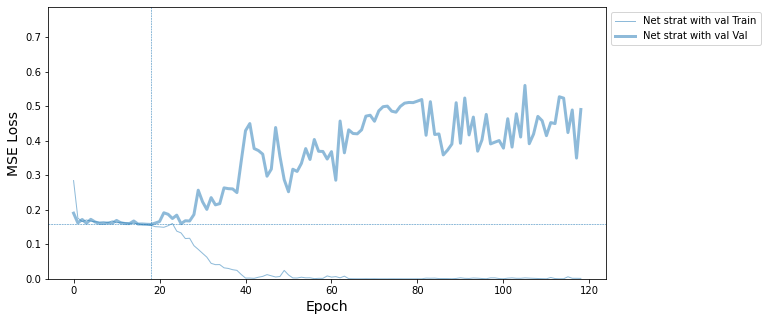

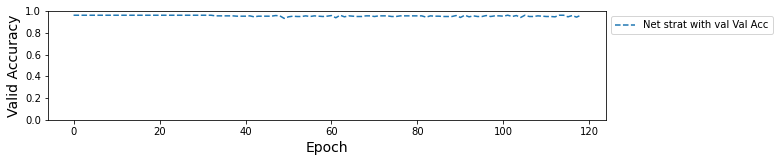

In [24]:
nets = [
    (net_strat_val,'Net strat with val'),
]

sk_loss_plot(nets)

ys torch.Size([1362, 1])
ypreds (1362, 1)
['82']
in single task:


imod  precision  recall  f1-score  support
0   82        1.0     1.0       1.0       53

ys torch.Size([341, 1])
ypreds (341, 1)
['82']
in single task:


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


imod  precision  recall  f1-score  support
0   82        0.0     0.0       0.0       13

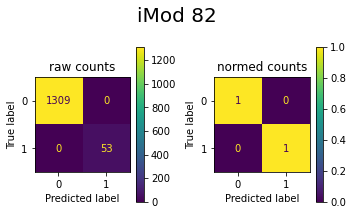

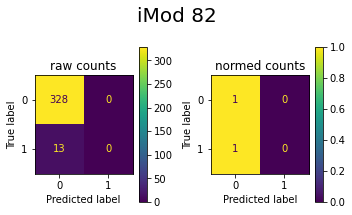

In [25]:
cls_full_train_df = view_cls_report(net_strat_val,Xtrain_strat,ytrain_strat,imod,st=True)
cls_val_df = view_cls_report(net_strat_val,Xval_strat,yval_strat,imod,st=True)

In [26]:
# classificaiton report won't accept single task! 
# It's fine with there's 15 or 3 but can't do 1 - 
# it thinks there should be labels explicitly provided...
# Why don't these two follow the same format? Am i misunderstanding the multi-task version
# and interpretting it wrong?

# just... calculate individual scores in "single task mode" and move on

## BCEwithlogitsloss reweighting?

In [27]:
def get_class_counts(ys):
    '''
    Given a list of iMod vector labels, sum the number of
    positive examples for each iModulon
    '''
    y_sum = torch.tensor(np.zeros(ys.shape[1]))
    for ex in ys:
        y_sum += ex

    return y_sum

# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_pos_weights(ys):
    '''
    Determine loss reweighting vector by the inverse of the positive
    examples for each iMod task
    '''
    class_counts = get_class_counts(ys)
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        print(f"{cdx}| pos:{pos_count}  neg:{neg_count}")
        print("val:", neg_count / (pos_count + 1e-5))
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [28]:
bce_pos_weights = get_pos_weights(y)

0| pos:82.0  neg:2047.0
val: tensor(24.9634, dtype=torch.float64)


In [29]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [30]:
net_strat_bcew.fit(Xtrain_strat, ytrain_strat)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3471       0.9619        1.3272  0.2957
      2        1.3404       0.9619        1.3265  0.1574
      3        1.3386       0.8416        1.3265  0.1463
      4        1.3398       0.9619        1.3278  0.1430
      5        1.3487       0.9619        1.3284  0.1395
      6        1.3359       0.0381        1.3264  0.1391
      7        1.3389       0.2757        1.3267  0.1424
      8        1.3273       0.9619        1.3298  0.1439
      9        1.3300       0.4604        1.3283  0.1432
     10        1.2963       0.9238        1.3510  0.1423
     11        1.2699       0.5513        1.3481  0.1419
     12        1.1607       0.8240        1.6197  0.1436
     13        1.0005       0.6569        1.6561  0.1446
     14        0.8214       0.8974        2.8063  0.1415
     15        0.7270       0.8504        2.3488  0.1444
     16        0.5397       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

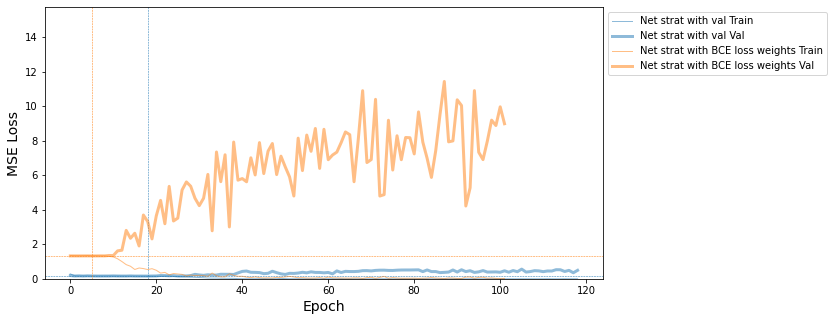

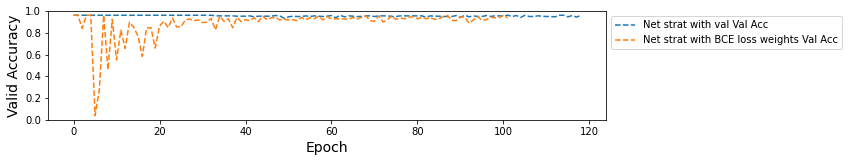

In [31]:
nets = [
    (net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights')
]

sk_loss_plot(nets,yscaler=100)

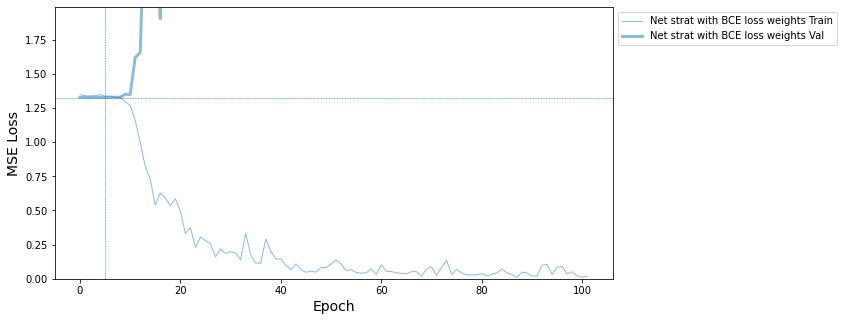

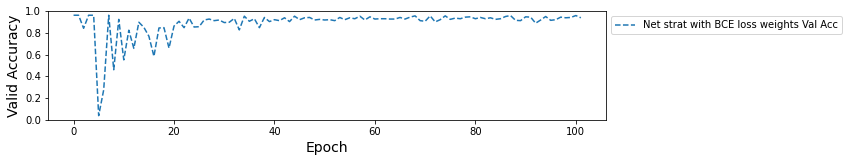

In [32]:

sk_loss_plot([(net_strat_bcew,'Net strat with BCE loss weights')],yscaler=1.5)

ys torch.Size([1362, 1])
ypreds (1362, 1)
['82']
in single task:


imod  precision  recall  f1-score  support
0   82        1.0     1.0       1.0       53

ys torch.Size([341, 1])
ypreds (341, 1)
['82']
in single task:


imod  precision  recall  f1-score  support
0   82        0.0     0.0       0.0       13

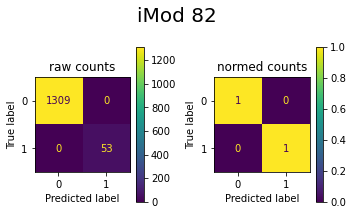

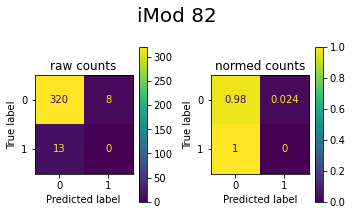

In [35]:
cls_full_train_df = view_cls_report(net_strat_bcew,Xtrain_strat,ytrain_strat,imod,st=True)
cls_val_df = view_cls_report(net_strat_bcew,Xval_strat,yval_strat,imod,st=True)

## fiddle with params with bce weights

In [37]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew_tink1 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=3,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=5000,
    lr=0.0001,
    batch_size=256,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=3000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [38]:
net_strat_bcew_tink1.fit(Xtrain_strat,ytrain_strat)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3405       0.0381        1.3269  0.1702
      2        1.3391       0.0381        1.3266  0.1154
      3        1.3378       0.0381        1.3263  0.0965
      4        1.3381       0.0381        1.3261  0.0876
      5        1.3364       0.0381        1.3264  0.0856
      6        1.3351       0.0381        1.3267  0.0827
      7        1.3356       0.0381        1.3264  0.0841
      8        1.3331       0.0381        1.3268  0.0809
      9        1.3329       0.0352        1.3269  0.0829
     10        1.3289       0.0381        1.3269  0.0845
     11        1.3277       0.0821        1.3269  0.0821
     12        1.3247       0.3284        1.3268  0.0846
     13        1.3242       0.0381        1.3278  0.0809
     14        1.3182       0.4575        1.3272  0.0834
     15        1.3136       0.5836        1.3271  0.0827
     16        1.3098       0.9

    130        0.0950       0.9355        3.5913  0.0829
    131        0.0825       0.9384        3.7722  0.0835
    132        0.0985       0.9384        3.7260  0.0870
    133        0.0838       0.9384        3.9194  0.0865
    134        0.0703       0.9501        4.3317  0.0831
    135        0.0903       0.9238        3.5666  0.0856
    136        0.1053       0.9296        3.6276  0.0825
    137        0.0815       0.9413        4.1850  0.0878
    138        0.0901       0.9208        3.4568  0.0868
    139        0.0832       0.9413        4.1993  0.0825
    140        0.0701       0.9384        4.1121  0.0860
    141        0.0578       0.9384        4.0706  0.0816
    142        0.0654       0.9413        4.2802  0.0852
    143        0.0735       0.9384        4.1541  0.0846
    144        0.0946       0.9238        3.5901  0.0858
    145        0.0714       0.9384        4.1429  0.0828
    146        0.0433       0.9560        4.9976  0.0827
    147        0.0940       0.9

    272        0.0226       0.9472        6.1750  0.0858
    273        0.0202       0.9413        5.7225  0.0867
    274        0.0235       0.9326        5.1854  0.0837
    275        0.0250       0.9472        6.1470  0.0825
    276        0.0188       0.9589        6.7477  0.0827
    277        0.0314       0.9384        5.5140  0.0839
    278        0.0359       0.9208        4.7165  0.0869
    279        0.0349       0.9472        6.3616  0.0877
    280        0.0216       0.9589        6.9172  0.0870
    281        0.0283       0.9443        6.0383  0.0874
    282        0.0238       0.9384        5.5199  0.0832
    283        0.0269       0.9443        6.0852  0.0858
    284        0.0352       0.9443        6.0684  0.0849
    285        0.0150       0.9443        6.1728  0.0855
    286        0.0377       0.9384        5.5117  0.0848
    287        0.0228       0.9384        5.4863  0.0843
    288        0.0201       0.9443        6.1083  0.0846
    289        0.0250       0.9

    415        0.0178       0.9384        6.3955  0.0832
    416        0.0114       0.9531        7.2571  0.0857
    417        0.0195       0.9531        7.2349  0.0836
    418        0.0059       0.9384        6.5168  0.0853
    419        0.0365       0.9384        6.0492  0.0823
    420        0.0240       0.9355        6.2358  0.0816
    421        0.0179       0.9560        7.3660  0.0831
    422        0.0056       0.9472        6.7760  0.0829
    423        0.0112       0.9443        6.7255  0.0889
    424        0.0140       0.9443        6.5664  0.0846
    425        0.0107       0.9472        6.8207  0.0887
    426        0.0136       0.9501        7.1211  0.0858
    427        0.0077       0.9531        7.1997  0.0874
    428        0.0106       0.9531        7.2253  0.0847
    429        0.0169       0.9443        6.6785  0.1609
    430        0.0070       0.9384        6.5326  0.0829
    431        0.0083       0.9531        7.2781  0.0824
    432        0.0446       0.9

    559        0.0064       0.9560        7.7768  0.0850
    560        0.0048       0.9589        8.1365  0.0876
    561        0.0041       0.9619        8.1994  0.0828
    562        0.0041       0.9560        7.8238  0.0881
    563        0.0037       0.9531        7.4826  0.0869
    564        0.0038       0.9531        7.5774  0.0830
    565        0.0072       0.9560        7.9258  0.0866
    566        0.0104       0.9531        7.5026  0.0819
    567        0.0038       0.9501        7.4575  0.0853
    568        0.0026       0.9560        7.8134  0.0861
    569        0.0044       0.9560        8.0309  0.0841
    570        0.0401       0.9267        6.1607  0.0861
    571        0.0159       0.9384        6.4858  0.0855
    572        0.0071       0.9560        7.5982  0.0839
    573        0.0036       0.9589        8.4008  0.0821
    574        0.0058       0.9619        8.6187  0.0854
    575        0.0032       0.9589        8.2592  0.0861
    576        0.0037       0.9

    703        0.0029       0.9619        9.3861  0.0862
    704        0.0028       0.9619        9.6931  0.0851
    705        0.0014       0.9619        9.7333  0.0836
    706        0.0062       0.9589        9.0306  0.0862
    707        0.0111       0.9413        7.6585  0.0844
    708        0.0053       0.9413        7.5979  0.0852
    709        0.0053       0.9531        8.4542  0.0868
    710        0.0017       0.9619        9.3504  0.0861
    711        0.0049       0.9589        9.2790  0.0842
    712        0.0030       0.9589        9.1876  0.0854
    713        0.0028       0.9589        9.2918  0.0835
    714        0.0010       0.9619        9.4532  0.0829
    715        0.0036       0.9589        9.1314  0.0848
    716        0.0017       0.9560        8.9167  0.0838
    717        0.0150       0.9413        7.6483  0.0851
    718        0.0095       0.9355        7.2129  0.0815
    719        0.0059       0.9472        8.1924  0.0817
    720        0.0022       0.9

    846        0.0024       0.9472        8.5050  0.0847
    847        0.0039       0.9560        9.0462  0.0867
    848        0.0027       0.9589        9.8527  0.0862
    849        0.0088       0.9560        9.1991  0.0879
    850        0.0035       0.9501        8.4463  0.0838
    851        0.0035       0.9443        8.3401  0.0862
    852        0.0015       0.9560        8.8075  0.0880
    853        0.0051       0.9560        9.0611  0.0847
    854        0.0032       0.9560        9.3392  0.0819
    855        0.0034       0.9560        9.3415  0.0857
    856        0.0018       0.9560        9.2328  0.0840
    857        0.0009       0.9560        9.1097  0.0820
    858        0.0022       0.9560        9.0776  0.0817
    859        0.0031       0.9560        8.9360  0.0823
    860        0.0044       0.9501        8.6946  0.0861
    861        0.0014       0.9560        9.1462  0.0846
    862        0.0015       0.9589        9.6493  0.0865
    863        0.0016       0.9

    990        0.0025       0.9443        8.5122  0.0869
    991        0.0014       0.9501        8.7170  0.0836
    992        0.0012       0.9531        9.1712  0.0858
    993        0.0015       0.9619        9.6904  0.0823
    994        0.0005       0.9619       10.0636  0.0858
    995        0.0005       0.9619       10.2453  0.0820
    996        0.0008       0.9619       10.2288  0.0818
    997        0.0013       0.9619       10.2911  0.0822
    998        0.0014       0.9619       10.2524  0.0822
    999        0.0005       0.9619       10.1157  0.0861
   1000        0.0060       0.9531        9.4396  0.0875
   1001        0.0027       0.9501        8.6494  0.0866
   1002        0.0023       0.9501        8.6048  0.0886
   1003        0.0028       0.9501        9.2090  0.0850
   1004        0.0006       0.9589        9.7781  0.0846
   1005        0.0024       0.9619       10.0632  0.0848
   1006        0.0043       0.9531        9.6080  0.0830
   1007        0.0021       0.9

   1134        0.0016       0.9589       10.0664  0.0838
   1135        0.0094       0.9501        9.1286  0.0818
   1136        0.0029       0.9472        8.3152  0.0830
   1137        0.0042       0.9472        8.3470  0.0837
   1138        0.0031       0.9501        8.9278  0.0829
   1139        0.0016       0.9501        9.5103  0.0863
   1140        0.0028       0.9589        9.7289  0.0861
   1141        0.0037       0.9531        9.6502  0.0883
   1142        0.0023       0.9501        9.5208  0.0849
   1143        0.0015       0.9589       10.0344  0.0860
   1144        0.0057       0.9560        9.7481  0.1542
   1145        0.0017       0.9501        9.2361  0.0855
   1146        0.0027       0.9501        9.2563  0.0862
   1147        0.0010       0.9501        9.3165  0.0833
   1148        0.0021       0.9501        9.4015  0.0879
   1149        0.0019       0.9501        9.1930  0.0843
   1150        0.0015       0.9501        9.3057  0.0831
   1151        0.0050       0.9

   1278        0.0004       0.9589       10.6560  0.0884
   1279        0.0053       0.9501        9.4897  0.0867
   1280        0.0008       0.9472        9.0467  0.0872
   1281        0.0010       0.9472        9.0630  0.0877
   1282        0.0022       0.9501        9.4436  0.0837
   1283        0.0005       0.9531        9.7611  0.0845
   1284        0.0002       0.9531       10.0041  0.0852
   1285        0.0023       0.9560       10.2997  0.0883
   1286        0.0009       0.9560       10.3848  0.0877
   1287        0.0003       0.9560       10.4010  0.0871
   1288        0.0003       0.9560       10.4570  0.0838
   1289        0.0010       0.9589       10.6202  0.0843
   1290        0.0002       0.9589       10.7114  0.0868
   1291        0.0007       0.9619       10.8611  0.0894
   1292        0.0003       0.9619       10.9916  0.0878
   1293        0.0002       0.9619       11.0566  0.0868
   1294        0.0010       0.9619       10.9843  0.0872
   1295        0.0013       0.9

   1421        0.0002       0.9619       11.7835  0.0849
   1422        0.0034       0.9560       10.6842  0.0821
   1423        0.0008       0.9531       10.0372  0.0821
   1424        0.0011       0.9472        9.8668  0.0867
   1425        0.0006       0.9531       10.0710  0.0841
   1426        0.0007       0.9531       10.5773  0.0859
   1427        0.0003       0.9589       11.0368  0.0837
   1428        0.0002       0.9619       11.3779  0.0828
   1429        0.0004       0.9619       11.5998  0.0822
   1430        0.0003       0.9619       11.7848  0.0884
   1431        0.0008       0.9619       11.9741  0.0865
   1432        0.0003       0.9619       12.1897  0.0860
   1433        0.0009       0.9619       12.0754  0.0876
   1434        0.0002       0.9619       11.8899  0.0817
   1435        0.0004       0.9619       11.8560  0.0840
   1436        0.0004       0.9619       11.8890  0.0861
   1437        0.0003       0.9619       11.9512  0.0851
   1438        0.0001       0.9

   1565        0.0001       0.9619       12.5248  0.0827
   1566        0.0001       0.9619       12.5162  0.0823
   1567        0.0001       0.9619       12.4868  0.0823
   1568        0.0003       0.9619       12.3489  0.0817
   1569        0.0001       0.9619       12.2814  0.0816
   1570        0.0005       0.9619       12.3305  0.0821
   1571        0.0003       0.9619       12.5936  0.0815
   1572        0.0001       0.9619       12.7153  0.0812
   1573        0.0002       0.9619       12.7326  0.0809
   1574        0.0046       0.9560       11.1925  0.0803
   1575        0.0016       0.9501       10.3891  0.0809
   1576        0.0006       0.9531       10.8928  0.0806
   1577        0.0004       0.9589       11.3923  0.0809
   1578        0.0006       0.9589       11.9730  0.0819
   1579        0.0002       0.9619       12.3499  0.0812
   1580        0.0001       0.9619       12.5878  0.0807
   1581        0.0010       0.9619       12.4500  0.0816
   1582        0.0002       0.9

   1709        0.0021       0.9531       10.6945  0.0847
   1710        0.0008       0.9589       11.3684  0.0861
   1711        0.0003       0.9619       11.8270  0.0865
   1712        0.0009       0.9619       11.8605  0.0831
   1713        0.0007       0.9619       11.7919  0.0829
   1714        0.0002       0.9619       11.9599  0.0842
   1715        0.0010       0.9619       12.1401  0.0842
   1716        0.0008       0.9619       12.1453  0.0819
   1717        0.0003       0.9619       12.1111  0.0821
   1718        0.0004       0.9619       11.9887  0.0817
   1719        0.0001       0.9619       11.9166  0.0827
   1720        0.0006       0.9619       11.7620  0.0843
   1721        0.0001       0.9619       11.6793  0.0847
   1722        0.0004       0.9619       11.7732  0.0857
   1723        0.0002       0.9619       11.8103  0.0846
   1724        0.0001       0.9619       11.8462  0.0844
   1725        0.0005       0.9619       11.7329  0.0864
   1726        0.0001       0.9

   1853        0.0208       0.9296        8.3879  0.0896
   1854        0.0163       0.9355        8.6780  0.0901
   1855        0.0041       0.9589       11.3604  0.0899
   1856        0.0004       0.9619       13.5552  0.0861
   1857        0.0354       0.9619       11.6453  0.0822
   1858        0.0015       0.9384        8.7519  0.0850
   1859        0.0086       0.9384        8.7642  0.0873
   1860        0.0039       0.9531        9.9101  0.0854
   1861        0.0013       0.9560       10.9560  0.0835
   1862        0.0006       0.9589       11.4717  0.0843
   1863        0.0010       0.9589       11.4178  0.0858
   1864        0.0016       0.9560       11.1238  0.0863
   1865        0.0007       0.9531       10.0450  0.1589
   1866        0.0016       0.9531        9.9270  0.0840
   1867        0.0004       0.9531       10.0115  0.0822
   1868        0.0005       0.9531       10.1783  0.0824
   1869        0.0016       0.9531       10.5449  0.0826
   1870        0.0007       0.9

   1997        0.0008       0.9589       12.0157  0.0884
   1998        0.0026       0.9589       11.6226  0.0828
   1999        0.0001       0.9560       11.3274  0.0828
   2000        0.0004       0.9560       11.2875  0.0827
   2001        0.0008       0.9589       11.5094  0.0824
   2002        0.0003       0.9589       11.7667  0.0866
   2003        0.0006       0.9589       12.1345  0.0865
   2004        0.0001       0.9589       12.3787  0.0868
   2005        0.0002       0.9589       12.4703  0.0880
   2006        0.0001       0.9589       12.5290  0.0865
   2007        0.0000       0.9589       12.5697  0.0860
   2008        0.0001       0.9589       12.5923  0.0831
   2009        0.0002       0.9589       12.6639  0.0855
   2010        0.0005       0.9589       12.6474  0.0877
   2011        0.0001       0.9589       12.5766  0.0872
   2012        0.0017       0.9589       11.9226  0.0865
   2013        0.0003       0.9589       11.5802  0.0843
   2014        0.0002       0.9

   2141        0.0063       0.9560       12.1673  0.0879
   2142        0.0001       0.9531       10.9062  0.0899
   2143        0.0001       0.9443       10.2839  0.0852
   2144        0.0012       0.9501       10.3307  0.0820
   2145        0.0010       0.9501       10.7421  0.0854
   2146        0.0007       0.9560       11.2318  0.0852
   2147        0.0018       0.9560       12.0125  0.0880
   2148        0.0002       0.9619       12.4872  0.0842
   2149        0.0000       0.9619       12.7668  0.0882
   2150        0.0001       0.9619       12.9444  0.0836
   2151        0.0006       0.9619       12.8246  0.0843
   2152        0.0001       0.9619       12.7339  0.0847
   2153        0.0001       0.9619       12.7162  0.0885
   2154        0.0000       0.9619       12.8040  0.0884
   2155        0.0006       0.9619       12.7413  0.0877
   2156        0.0001       0.9619       12.5238  0.0887
   2157        0.0001       0.9619       12.4164  0.0855
   2158        0.0001       0.9

   2285        0.0000       0.9619       13.6253  0.0866
   2286        0.0000       0.9619       13.6081  0.0901
   2287        0.0000       0.9619       13.5995  0.0864
   2288        0.0001       0.9619       13.5953  0.0859
   2289        0.0003       0.9619       13.4240  0.0857
   2290        0.0001       0.9619       13.3345  0.0871
   2291        0.0001       0.9619       13.3283  0.0896
   2292        0.0001       0.9619       13.4148  0.0893
   2293        0.0000       0.9619       13.4659  0.0839
   2294        0.0001       0.9619       13.5352  0.0879
   2295        0.0001       0.9619       13.5682  0.0887
   2296        0.0004       0.9619       13.6835  0.0887
   2297        0.0000       0.9619       13.7187  0.0842
   2298        0.0004       0.9619       13.8400  0.0844
   2299        0.0001       0.9619       13.9839  0.0872
   2300        0.0001       0.9619       14.0710  0.0855
   2301        0.0001       0.9619       14.1325  0.0839
   2302        0.0001       0.9

   2429        0.0000       0.9619       15.0584  0.0860
   2430        0.0000       0.9619       15.0579  0.0868
   2431        0.0000       0.9619       15.0347  0.0859
   2432        0.0000       0.9619       15.0201  0.0884
   2433        0.0001       0.9619       14.9507  0.0835
   2434        0.0001       0.9619       14.8569  0.0876
   2435        0.0001       0.9619       14.7524  0.0825
   2436        0.0001       0.9619       14.5812  0.0824
   2437        0.0000       0.9619       14.4816  0.0871
   2438        0.0001       0.9619       14.4641  0.0865
   2439        0.0001       0.9619       14.4243  0.0857
   2440        0.0000       0.9619       14.3777  0.0872
   2441        0.0014       0.9619       14.8376  0.0845
   2442        0.0000       0.9619       15.1244  0.0821
   2443        0.0000       0.9619       15.2736  0.0862
   2444        0.0000       0.9619       15.3534  0.0815
   2445        0.0000       0.9619       15.3950  0.0815
   2446        0.0005       0.9

   2573        0.0007       0.9589       12.7843  0.0864
   2574        0.0000       0.9589       12.9052  0.0880
   2575        0.0000       0.9589       12.9833  0.0834
   2576        0.0001       0.9589       13.1019  0.0883
   2577        0.0001       0.9589       13.1926  0.0837
   2578        0.0001       0.9589       13.2615  0.0851
   2579        0.0000       0.9589       13.3626  0.0847
   2580        0.0000       0.9589       13.4232  0.0867
   2581        0.0000       0.9589       13.4797  0.0820
   2582        0.0005       0.9619       13.6707  0.0817
   2583        0.0001       0.9619       13.7712  0.0819
   2584        0.0006       0.9619       13.6510  0.0854
   2585        0.0000       0.9589       13.3391  0.0872
   2586        0.0001       0.9589       13.2397  0.0874
   2587        0.0000       0.9589       13.2137  0.0865
   2588        0.0001       0.9589       13.1994  0.0840
   2589        0.0000       0.9589       13.1905  0.0883
   2590        0.0000       0.9

   2717        0.0010       0.9443        9.6460  0.0857
   2718        0.0001       0.9501       10.2773  0.0866
   2719        0.0079       0.9443        9.3908  0.0856
   2720        0.0026       0.9443        9.1461  0.0819
   2721        0.0034       0.9443        9.7548  0.0844
   2722        0.0002       0.9501       10.3282  0.0873
   2723        0.0043       0.9560       11.0488  0.0867
   2724        0.0002       0.9560       11.5987  0.0864
   2725        0.0000       0.9589       11.9787  0.0880
   2726        0.0001       0.9589       12.1726  0.0859
   2727        0.0005       0.9589       12.1906  0.0844
   2728        0.0039       0.9560       11.0236  0.0881
   2729        0.0028       0.9560       10.6528  0.0864
   2730        0.0001       0.9501       10.5287  0.0874
   2731        0.0002       0.9501       10.5251  0.0884
   2732        0.0025       0.9501       10.3331  0.0867
   2733        0.0007       0.9501       10.2161  0.0843
   2734        0.0003       0.9

   2861        0.0018       0.9560       11.6876  0.0849
   2862        0.0002       0.9560       11.8295  0.0887
   2863        0.0001       0.9560       11.9148  0.0882
   2864        0.0008       0.9589       12.0810  0.0837
   2865        0.0004       0.9589       12.0882  0.0856
   2866        0.0003       0.9589       12.1505  0.0871
   2867        0.0003       0.9589       12.2564  0.0867
   2868        0.0000       0.9589       12.3136  0.0897
   2869        0.0008       0.9589       12.4137  0.0854
   2870        0.0004       0.9589       12.5200  0.0838
   2871        0.0072       0.9560       11.2382  0.0844
   2872        0.0004       0.9531       10.4325  0.0884
   2873        0.0002       0.9560       10.1277  0.0894
   2874        0.0004       0.9560       10.0378  0.0887
   2875        0.0006       0.9531       10.1779  0.0896
   2876        0.0002       0.9531       10.3050  0.0835
   2877        0.0004       0.9531       10.4695  0.0835
   2878        0.0008       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2976, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

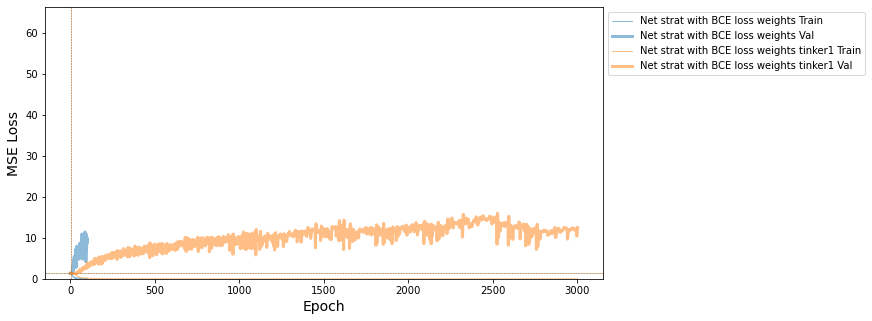

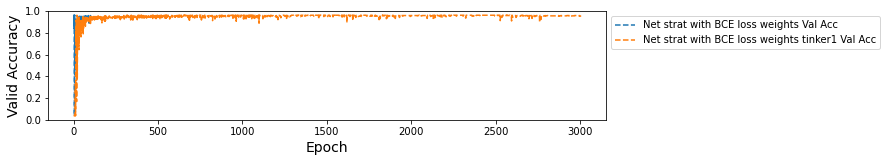

In [39]:
nets = [
    #(net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights'),
    (net_strat_bcew_tink1,'Net strat with BCE loss weights tinker1'),
#     (net_strat_bcew_tink2,'Net strat with BCE loss weights tinker2'),
#     (net_strat_bcew_tink3,'Net strat with BCE loss weights tinker3'),
#     (net_strat_bcew_tink4,'Net strat with BCE loss weights tinker4'),
#     (net_strat_bcew_tink5,'Net strat with BCE loss weights tinker5'),
]


sk_loss_plot(nets,yscaler=50)

ys torch.Size([1362, 1])
ypreds (1362, 1)
['82']
in single task:


imod  precision  recall  f1-score  support
0   82        1.0     1.0       1.0       53

ys torch.Size([341, 1])
ypreds (341, 1)
['82']
in single task:


imod  precision  recall  f1-score  support
0   82        0.0     0.0       0.0       13

ys torch.Size([426, 1])
ypreds (426, 1)
['82']
in single task:


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


imod  precision  recall  f1-score  support
0   82        0.0     0.0       0.0       16

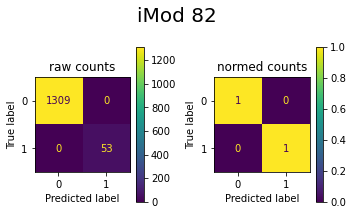

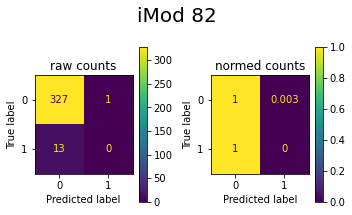

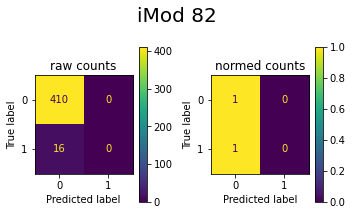

In [40]:
cls_full_train_df = view_cls_report(net_strat_bcew_tink1,Xtrain_strat,ytrain_strat,imod,st=True)
cls_val_df = view_cls_report(net_strat_bcew_tink1,Xval_strat,yval_strat,imod,st=True)
cls_test_df = view_cls_report(net_strat_bcew_tink1,Xtest_strat,ytest_strat,imod,st=True)

In [42]:
net_strat_bcew_tink1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2976, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

# SKORCH search

In [45]:
from sklearn.model_selection import RandomizedSearchCV


In [46]:
valid_ds = Dataset(Xval_strat, yval_strat)

net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    #train_split=ValidSplit(0.2),
    #train_split=None,
    #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=k_fold,
    train_split=predefined_split(valid_ds),
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=3000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         #EarlyStopping(patience=100),
         EarlyStopping(patience=1000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [47]:
params = {
    'lr': [0.001, 0.0005, 0.0001,],#loguniform(0.0001, 0.01)
    'batch_size':[32,64,128,256],
    'module__num_filters1': [32,64,128,256],
    'module__num_filters2': [32,64,128],
    'module__kernel_size1': [8,16,32],
    'module__kernel_size2': [8,16,32],
    'module__conv_pool_size1': [2,3],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer':[torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [50]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=1000, 
    #scoring='neg_mean_squared_error', 
    #scoring=['precision','recall','f1_macro'], 
    scoring=['f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    cv=3,#cv, 
    #cv=k_fold.split(Xtrain_strat,ytrain_strat),
    #cv=k_fold,
    random_state=7,
    verbose=1
)

In [ ]:
search.fit(Xtrain_strat,ytrain_strat)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 181.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 457.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 792.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 1236.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 1796.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 2420.1min


In [53]:
1+3

4

In [55]:
search.cv_results_

{'mean_fit_time': array([ 174.07894079,   83.88609799,  295.32869077,  286.08445581,
         193.30905135,  114.03280417,  256.35039822,   92.50197872,
         131.08863688,   96.70305689,  120.39569887,  125.452003  ,
         307.22088798,  151.2880408 ,  289.23950553,  134.64663959,
         333.61997493,  241.0977385 ,  228.69053046,  261.78293395,
         145.68463524,  499.0533514 ,  155.42702905,  293.57449309,
         300.49766954,  134.76461673,  453.64425882,  125.92694068,
         143.39413913,  136.78186544,  196.27306   ,  215.54068915,
         473.94807347,  416.01729608,  249.6036977 ,  204.88969096,
          94.53324032,  160.07969507,  588.62135243,  213.8236773 ,
         471.72423824,  284.73614057,  191.2986335 ,  171.72488268,
         284.13786681,  107.72890178,  181.56782587,  317.22650735,
         184.29096103,  162.16202561,  224.37885873,  118.94939613,
         291.55802298,  189.36642027,  345.283892  ,  144.73310773,
         273.08628289,  180.039

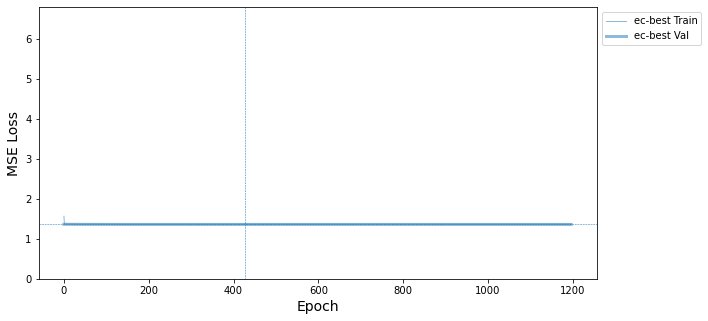

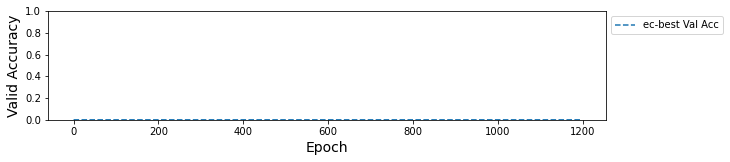

In [58]:
netss = [
    #(net_randsplit,"RandSplit"),
    #(net_strat_bcew_tink5,"StratSplit5"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(netss)

### inspect hyperparam search results

In [59]:
search.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 256, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.0, inplace=False)
      (4): Conv2d(256, 128, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.0, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=17792, out_features=500, bias=True)
      (9): ReLU()
      (10): Linear(in_features=500, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=15, bias=True)
    )
  ),
)

In [60]:
search.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__num_filters2': 128,
 'module__num_filters1': 256,
 'module__kernel_size2': 8,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 10,
 'module__fc_node_num1': 500,
 'module__dropout2': 0.0,
 'module__dropout1': 0.0,
 'module__conv_pool_size1': 2,
 'lr': 0.0005,
 'batch_size': 64}

In [61]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       174.078941      3.055924         0.036090        0.006722   
1        83.886098     11.036187         0.018459        0.000425   
2       295.328691      2.136481         0.047441        0.004097   
3       286.084456      0.462509         0.038869        0.006066   
4       193.309051      0.868605         0.026572        0.001879   
..             ...           ...              ...             ...   
995     136.523441      5.103961         0.023055        0.001362   
996     433.902389     98.855534         0.056283        0.005334   
997     340.599303     12.392051         0.048607        0.002753   
998     189.293604      5.674480         0.042487        0.003305   
999     143.547474      8.072270         0.015087        0.003057   

                           param_optimizer param_module__num_filters2  \
0    <class 'torch.optim.rmsprop.RMSprop'>                         32   
1            <class 'torch.optim.sgd.SGD'>                         64   
2          <class 'torch.optim.adam.Adam'>                         64   
3        <class 'torch.optim.adamw.AdamW'>                        128   
4    <class 'torch.optim.rmsprop.RMSprop'>                        128   
..                                     ...                        ...   
995          <class 'torch.optim.sgd.SGD'>                        128   
996          <class 'torch.optim.sgd.SGD'>                         32   
997  <class 'torch.optim.rmsprop.RMSprop'>                         64   
998          <class 'torch.optim.sgd.SGD'>                         32   
999  <class 'torch.optim.rmsprop.RMSprop'>                        128   

    param_module__num_filters1 param_module__kernel_size2  \
0                           64                         32   
1                           32                         32   
2                          256                         32   
3                           64                         16   
4                          128                         16   
..                         ...                        ...   
995                         64                          8   
996                        256                         16   
997                        128                         16   
998                        128                         16   
999                         64                         16   

    param_module__kernel_size1 param_module__fc_node_num2  ... param_lr  \
0                            8                         10  ...   0.0005   
1                            8                        100  ...    0.001   
2                           16                         10  ...   0.0005   
3                           16                        100  ...   0.0005   
4                            8                         10  ...    0.001   
..                         ...                        ...  ...      ...   
995                         16                         50  ...   0.0005   
996                         16                         50  ...    0.001   
997                         16                        500  ...   0.0005   
998                         16                         50  ...    0.001   
999                          8                         10  ...    0.001   

    param_batch_size                                             params  \
0                 64  {'optimizer': <class 'torch.optim.rmsprop.RMSp...   
1                256  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...   
2                 64  {'optimizer': <class 'torch.optim.adam.Adam'>,...   
3                 64  {'optimizer': <class 'torch.optim.adamw.AdamW'...   
4                128  {'optimizer': <class 'torch.optim.rmsprop.RMSp...   
..               ...                                                ...   
995              256  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...   
996               32  {'optimizer': <class 'torch.optim.sgd.SGD'>

In [62]:
sm_res_df = res_df[[
    "rank_test_f1_macro",
    "mean_test_f1_macro",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [63]:
sm_res_df

rank_test_f1_macro  mean_test_f1_macro param_module__num_filters1  \
0                   511            0.010124                         64   
1                   503            0.010224                         32   
2                   412            0.010963                        256   
3                   778            0.004938                         64   
4                   746            0.005908                        128   
..                  ...                 ...                        ...   
995                 545            0.009781                         64   
996                  17            0.024743                        256   
997                 245            0.012516                        128   
998                 385            0.011256                        128   
999                 215            0.012903                         64   

    param_module__num_filters2 param_module__kernel_size1  \
0                           32                          8   
1                           64                          8   
2                           64                         16   
3                          128                         16   
4                          128                          8   
..                         ...                        ...   
995                        128                         16   
996                         32                         16   
997                         64                         16   
998                         32                         16   
999                        128                          8   

    param_module__kernel_size2 param_lr param_module__fc_node_num1  \
0                           32   0.0005                        500   
1                           32    0.001                         10   
2                           32   0.0005                         10   
3                           16   0.0005                         50   
4                           16    0.001                        100   
..                         ...      ...                        ...   
995                          8   0.0005                         50   
996                         16    0.001                        500   
997                         16   0.0005                        500   
998                         16    0.001                        100   
999                         16    0.001                         10   

    param_module__fc_node_num2 opt_name  
0                           10  RMSprop  
1                          100      SGD  
2                           10     Adam  
3                          100    AdamW  
4                           10  RMSprop  
..                         ...      ...  
995                         50      SGD  
996                         50      SGD  
997                        500  RMSprop  
998                         50      SGD  
999                         10  RMSprop  

[1000 rows x 10 columns]

In [64]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_f1_macro:Q',
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [65]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_f1_macro:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [66]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [67]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [68]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [69]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [70]:
res_df.to_csv('ec_iMod_out/hyper_clf_weightedLoss.tsv',sep='\t',index=False)

In [71]:
# best estimator predictions
cls_full_train_df = view_cls_report(search.best_estimator_,Xtrain_strat,ytrain_strat,imods_filt)
cls_full_val_df = view_cls_report(search.best_estimator_,Xval_strat,yval_strat,imods_filt)
cls_full_test_df = view_cls_report(search.best_estimator_,Xtest_strat,ytest_strat,imods_filt)


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running searchbest train


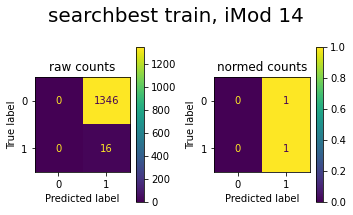

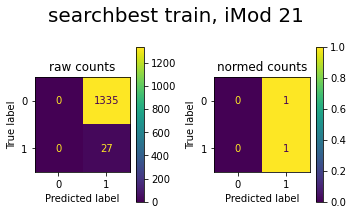

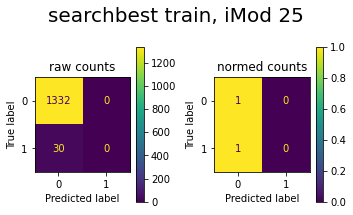

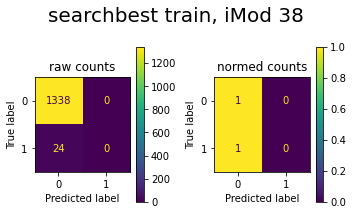

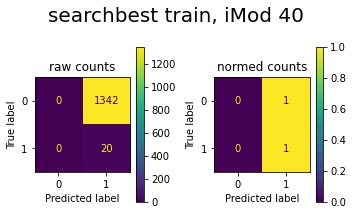

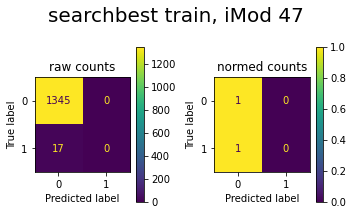

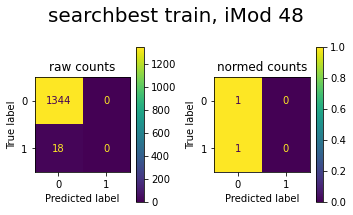

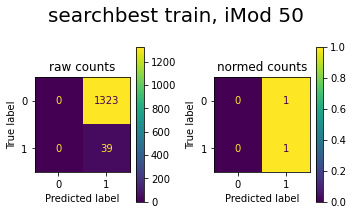

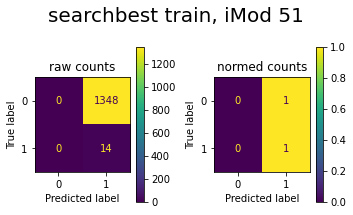

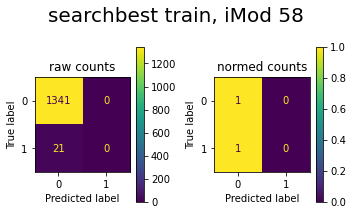

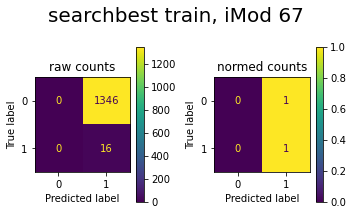

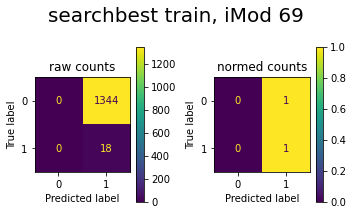

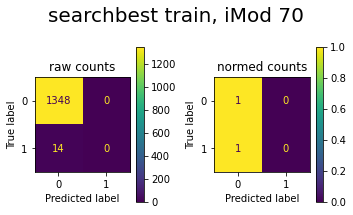

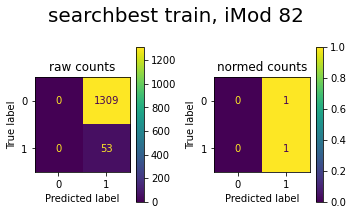

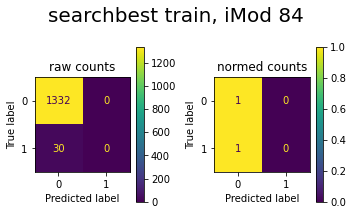

In [72]:
plot_confusion_multi([(search.best_estimator_,'searchbest train')], Xtrain_strat,ytrain_strat,imods_filt)

Running searchbest val


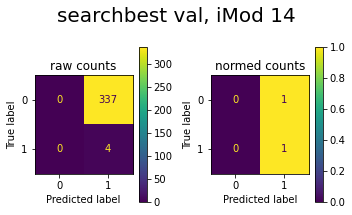

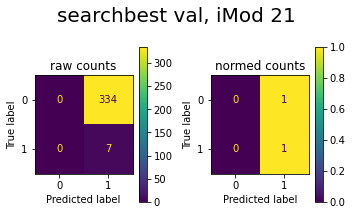

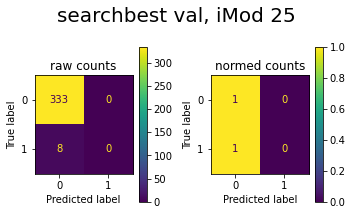

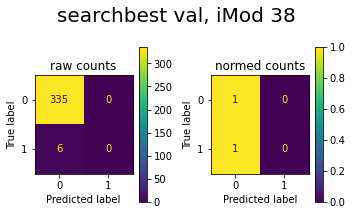

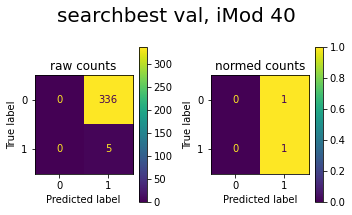

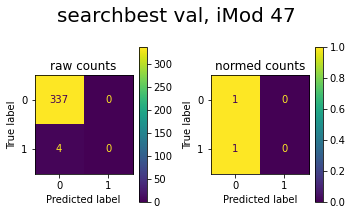

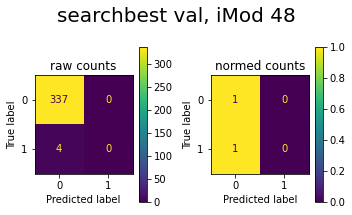

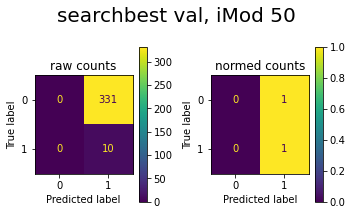

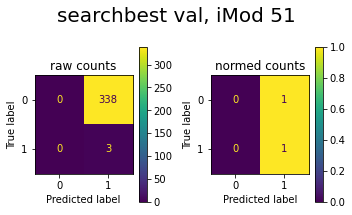

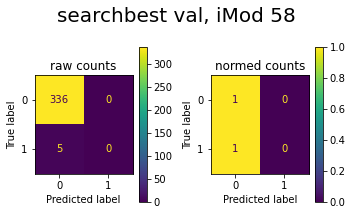

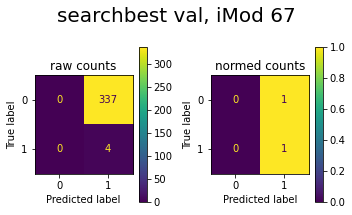

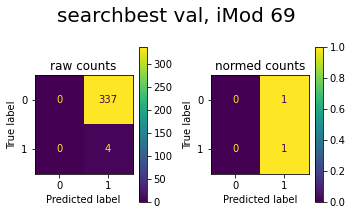

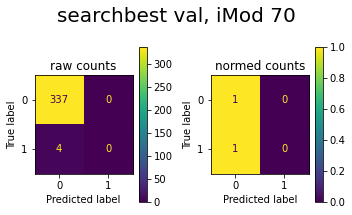

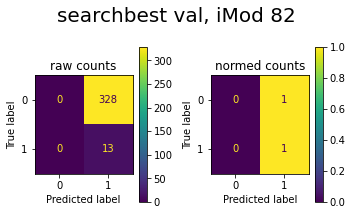

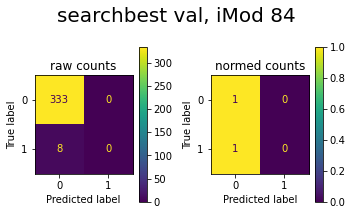

In [73]:
plot_confusion_multi([(search.best_estimator_,'searchbest val')], Xval_strat,yval_strat,imods_filt)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [74]:
net_cvp = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=None,
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200,monitor='train_loss'),
             # suggested monitoring train loss when i want to do gridsearchcv with early stop?
             # https://github.com/skorch-dev/skorch/issues/837
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None,
        verbose=1
    )

In [75]:
from sklearn.model_selection import cross_val_predict

In [76]:
y_pred = cross_val_predict(net_cvp, Xtrain_strat, ytrain_strat, cv=5)

# these instructions for using skorch with cross_val_predict don't work
# https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#validsplit

# when train_split=None, then "valid loss" is not in history
# when train_split is left default, it says StratifiedCV needs a suitable y

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5955  0.0902
      2        0.1069  0.0893
      3        0.0700  0.0672
      4        0.0555  0.0666
      5        0.0519  0.0659
      6        0.0500  0.0603
      7        0.0489  0.0582
      8        0.0483  0.0583
      9        0.0483  0.0579
     10        0.0482  0.0589
     11        0.0484  0.0579
     12        0.0480  0.0546
     13        0.0482  0.0576
     14        0.0481  0.0568
     15        0.0482  0.0570
     16        0.0481  0.0566
     17        0.0478  0.0570
     18        0.0479  0.0573
     19        0.0480  0.0577
     20        0.0482  0.0584
     21        0.0480  0.0583
     22        0.0474  0.0579
     23        0.0474  0.0584
     24        0.0475  0.0580
     25        0.0473  0.0587
     26        0.0475  0.0579
     27        0.0471  0.0580
     28        0.0468  0.0579
     29        0.0467  0.0580
     30        0.0475  0.0579
     31        0.0467  0.0579
     32   

    241        0.0040  0.0555
    242        0.0042  0.0554
    243        0.0048  0.0555
    244        0.0046  0.0555
    245        0.0056  0.0559
    246        0.0044  0.0558
    247        0.0041  0.0557
    248        0.0039  0.0556
    249        0.0042  0.0562
    250        0.0039  0.0563
    251        0.0050  0.0559
    252        0.0035  0.0559
    253        0.0051  0.0562
    254        0.0055  0.0564
    255        0.0051  0.0559
    256        0.0049  0.0558
    257        0.0048  0.0556
    258        0.0043  0.0556
    259        0.0032  0.0557
    260        0.0041  0.0557
    261        0.0041  0.0561
    262        0.0053  0.0556
    263        0.0037  0.0556
    264        0.0036  0.0555
    265        0.0048  0.0558
    266        0.0035  0.0559
    267        0.0043  0.0559
    268        0.0038  0.0556
    269        0.0039  0.0556
    270        0.0046  0.0557
    271        0.0048  0.0559
    272        0.0034  0.0561
    273        0.0041  0.0560
    274   

    512        0.0060  0.0582
    513        0.0043  0.0582
    514        0.0047  0.0585
    515        0.0046  0.0586
    516        0.0044  0.0578
    517        0.0053  0.0577
    518        0.0054  0.0579
    519        0.0048  0.0578
    520        0.0041  0.0576
    521        0.0032  0.0577
    522        0.0041  0.0578
    523        0.0040  0.0577
    524        0.0043  0.0577
    525        0.0036  0.0575
    526        0.0025  0.0576
    527        0.0043  0.0575
    528        0.0034  0.0576
    529        0.0039  0.0573
    530        0.0046  0.0574
    531        0.0039  0.0578
    532        0.0045  0.0575
    533        0.0029  0.0576
    534        0.0039  0.0578
    535        0.0039  0.0578
    536        0.0041  0.0576
    537        0.0043  0.0579
    538        0.0040  0.0577
    539        0.0043  0.0580
    540        0.0049  0.0576
    541        0.0033  0.0578
    542        0.0047  0.0575
    543        0.0041  0.0576
    544        0.0037  0.0579
    545   

      2        0.1280  0.0578
      3        0.0697  0.0594
      4        0.0581  0.0584
      5        0.0525  0.0580
      6        0.0507  0.0581
      7        0.0489  0.0585
      8        0.0486  0.0586
      9        0.0484  0.0581
     10        0.0486  0.0574
     11        0.0481  0.0575
     12        0.0482  0.0577
     13        0.0481  0.0576
     14        0.0482  0.0573
     15        0.0485  0.0574
     16        0.0485  0.0574
     17        0.0478  0.0576
     18        0.0482  0.0569
     19        0.0481  0.0574
     20        0.0480  0.0579
     21        0.0478  0.0576
     22        0.0475  0.0566
     23        0.0476  0.0555
     24        0.0475  0.0558
     25        0.0473  0.0559
     26        0.0474  0.0559
     27        0.0473  0.0555
     28        0.0472  0.0555
     29        0.0471  0.0557
     30        0.0468  0.0565
     31        0.0470  0.0551
     32        0.0469  0.0552
     33        0.0466  0.0551
     34        0.0467  0.0555
     35   

    242        0.0029  0.0555
    243        0.0029  0.0556
    244        0.0027  0.0556
    245        0.0029  0.0557
    246        0.0034  0.0575
    247        0.0027  0.0585
    248        0.0036  0.0589
    249        0.0029  0.0586
    250        0.0045  0.0586
    251        0.0036  0.0584
    252        0.0033  0.0584
    253        0.0038  0.0585
    254        0.0037  0.0588
    255        0.0043  0.0583
    256        0.0034  0.0582
    257        0.0040  0.0584
    258        0.0032  0.0585
    259        0.0036  0.0592
    260        0.0036  0.0593
    261        0.0031  0.0587
    262        0.0031  0.0586
    263        0.0027  0.0583
    264        0.0032  0.0579
    265        0.0025  0.0589
    266        0.0033  0.0585
    267        0.0037  0.0584
    268        0.0032  0.0582
    269        0.0038  0.0585
    270        0.0032  0.0580
    271        0.0047  0.0579
    272        0.0038  0.0571
    273        0.0037  0.0571
    274        0.0026  0.0579
    275   

    514        0.0042  0.0586
    515        0.0042  0.0590
    516        0.0031  0.0592
    517        0.0031  0.0587
    518        0.0047  0.0586
    519        0.0042  0.0583
    520        0.0038  0.0592
    521        0.0042  0.0591
    522        0.0033  0.0586
    523        0.0045  0.0587
    524        0.0041  0.0585
    525        0.0047  0.0587
    526        0.0037  0.0594
    527        0.0053  0.0584
    528        0.0041  0.0586
    529        0.0057  0.0587
    530        0.0039  0.0585
    531        0.0032  0.0586
    532        0.0023  0.0586
    533        0.0026  0.0587
    534        0.0026  0.0583
    535        0.0034  0.0589
    536        0.0038  0.0586
    537        0.0031  0.0590
    538        0.0040  0.0587
    539        0.0038  0.0584
    540        0.0027  0.0589
    541        0.0038  0.0585
    542        0.0063  0.0586
    543        0.0039  0.0587
    544        0.0051  0.0585
    545        0.0041  0.0582
    546        0.0045  0.0584
    547   

     89        0.0056  0.0551
     90        0.0052  0.0551
     91        0.0049  0.0548
     92        0.0048  0.0550
     93        0.0050  0.0545
     94        0.0044  0.0563
     95        0.0047  0.0550
     96        0.0043  0.0551
     97        0.0035  0.0552
     98        0.0034  0.0552
     99        0.0031  0.0551
    100        0.0030  0.0551
    101        0.0037  0.0552
    102        0.0028  0.0551
    103        0.0031  0.0551
    104        0.0028  0.0552
    105        0.0029  0.0551
    106        0.0033  0.0549
    107        0.0039  0.0550
    108        0.0035  0.0552
    109        0.0042  0.0556
    110        0.0036  0.0553
    111        0.0048  0.0552
    112        0.0035  0.0551
    113        0.0039  0.0551
    114        0.0031  0.0551
    115        0.0031  0.0551
    116        0.0037  0.0552
    117        0.0030  0.0546
    118        0.0026  0.0575
    119        0.0036  0.0574
    120        0.0031  0.0564
    121        0.0031  0.0561
    122   

    357        0.0020  0.0571
    358        0.0035  0.0572
    359        0.0029  0.0571
    360        0.0024  0.0572
    361        0.0021  0.0584
    362        0.0020  0.0577
    363        0.0022  0.0575
    364        0.0028  0.0577
    365        0.0036  0.0577
    366        0.0032  0.0560
    367        0.0043  0.0559
    368        0.0022  0.0560
    369        0.0033  0.0563
    370        0.0038  0.0560
    371        0.0020  0.0558
    372        0.0036  0.0557
    373        0.0049  0.0556
    374        0.0041  0.0558
    375        0.0044  0.0561
    376        0.0064  0.0560
    377        0.0059  0.0559
    378        0.0059  0.0560
    379        0.0042  0.0561
    380        0.0051  0.0558
    381        0.0052  0.0560
    382        0.0042  0.0554
    383        0.0030  0.0555
    384        0.0035  0.0554
    385        0.0041  0.0564
    386        0.0036  0.0562
    387        0.0028  0.0562
    388        0.0035  0.0559
    389        0.0036  0.0559
    390   

    190        0.0028  0.0550
    191        0.0032  0.0549
    192        0.0040  0.0550
    193        0.0034  0.0549
    194        0.0035  0.0549
    195        0.0041  0.0547
    196        0.0037  0.0547
    197        0.0040  0.0549
    198        0.0045  0.0548
    199        0.0045  0.0548
    200        0.0046  0.0549
    201        0.0044  0.0547
    202        0.0046  0.0546
    203        0.0043  0.0546
    204        0.0040  0.0547
    205        0.0040  0.0547
    206        0.0052  0.0549
    207        0.0050  0.0546
    208        0.0041  0.0548
    209        0.0034  0.0548
    210        0.0032  0.0550
    211        0.0031  0.0552
    212        0.0037  0.0550
    213        0.0037  0.0550
    214        0.0037  0.0550
    215        0.0032  0.0549
    216        0.0038  0.0550
    217        0.0042  0.0550
    218        0.0036  0.0549
    219        0.0032  0.0549
    220        0.0030  0.0548
    221        0.0039  0.0547
    222        0.0038  0.0550
    223   

    461        0.0025  0.0549
    462        0.0020  0.0549
    463        0.0019  0.0547
    464        0.0024  0.0548
    465        0.0017  0.0552
    466        0.0022  0.0554
    467        0.0028  0.0553
    468        0.0037  0.0551
    469        0.0029  0.0551
    470        0.0032  0.0550
    471        0.0034  0.0550
    472        0.0052  0.0550
    473        0.0050  0.0551
    474        0.0030  0.0551
    475        0.0040  0.0551
    476        0.0043  0.0550
    477        0.0029  0.0550
    478        0.0028  0.0549
    479        0.0032  0.0546
    480        0.0035  0.0548
    481        0.0042  0.0548
    482        0.0025  0.0549
    483        0.0037  0.0550
    484        0.0036  0.0550
    485        0.0038  0.0550
    486        0.0040  0.0548
    487        0.0035  0.0550
    488        0.0036  0.0550
    489        0.0021  0.0553
    490        0.0033  0.0552
    491        0.0029  0.0550
    492        0.0029  0.0551
    493        0.0032  0.0553
    494   

    187        0.0349  0.0550
    188        0.0349  0.0550
    189        0.0349  0.0551
    190        0.0349  0.0550
    191        0.0351  0.0551
    192        0.0349  0.0551
    193        0.0351  0.0552
    194        0.0350  0.0551
    195        0.0350  0.0549
    196        0.0350  0.0550
    197        0.0349  0.0556
    198        0.0348  0.0554
    199        0.0350  0.0557
    200        0.0350  0.0553
    201        0.0349  0.0550
    202        0.0349  0.0550
    203        0.0349  0.0549
    204        0.0349  0.0548
    205        0.0349  0.0549
    206        0.0349  0.0550
    207        0.0350  0.0549
    208        0.0349  0.0547
    209        0.0349  0.0551
    210        0.0349  0.0550
    211        0.0349  0.0552
    212        0.0348  0.0551
    213        0.0348  0.0549
    214        0.0349  0.0550
    215        0.0348  0.0548
    216        0.0349  0.0548
    217        0.0349  0.0548
Stopping since train_loss has not improved in the last 200 epochs.


In [77]:
netts = [
    #(search.best_estimator_,'ec-best_oldarch'),
    (net_cvp, 'manual cvp?')
]

sk_loss_plot(netts)

# errors because cross_val_predict doesn't actually train the model...?

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [78]:
net_cvp

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__conv_pool_size1=3,
  module__conv_pool_size2=1,
  module__dropout1=0.2,
  module__dropout2=0.2,
  module__fc_node_num1=100,
  module__fc_node_num2=100,
  module__kernel_size1=8,
  module__kernel_size2=8,
  module__n_tasks=58,
  module__num_filters1=128,
  module__num_filters2=64,
  module__seq_len=300,
)

In [79]:
y_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def view_cls_report2(yt,yp,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the classification report
    cls_rep = classification_report(yt, yp,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df

In [81]:
# from cross_val_predict preds
view_cls_report2(ytrain_strat,y_pred,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

imod  precision  recall  f1-score  support
0      0        0.0     0.0       0.0        6
1      1        0.0     0.0       0.0        3
2      2        0.0     0.0       0.0        4
3      5        0.0     0.0       0.0        6
4      7        0.0     0.0       0.0        4
5      8        0.0     0.0       0.0        6
6     10        0.0     0.0       0.0        5
7     11        0.0     0.0       0.0        5
8     12        0.0     0.0       0.0        4
9     13        0.0     0.0       0.0        5
10    14        0.0     0.0       0.0       16
11    16        0.0     0.0       0.0        7
12    17        0.0     0.0       0.0        7
13    19        0.0     0.0       0.0        8
14    21        0.0     0.0       0.0       27
15    22        0.0     0.0       0.0        3
16    25        0.0     0.0       0.0       30
17    28        0.0     0.0       0.0        4
18    29        0.0     0.0       0.0        5
19    30        0.0     0.0       0.0        6
20    31        0.0     0.0       0.0       10
21    34        0.0     0.0       0.0        4
22    38        0.0     0.0       0.0       24
23    39        0.0     0.0       0.0        5
24    40        0.0     0.0       0.0       20
25    41        0.0     0.0       0.0        4
26    42        0.0     0.0       0.0        4
27    44        0.0     0.0       0.0        8
28    45        0.0     0.0       0.0       10
29    47        0.0     0.0       0.0       17
30    48        0.0     0.0       0.0       18
31    50        0.0     0.0       0.0       39
32    51        0.0     0.0       0.0       14
33    54        0.0     0.0       0.0        8
34    55        0.0     0.0       0.0        8
35    58        0.0     0.0       0.0       21
36    59        0.0     0.0       0.0        7
37    61        0.0     0.0       0.0       11
38    63        0.0     0.0       0.0        6
39    64        0.0     0.0       0.0        7
40    65        0.0     0.0       0.0        8
41    66        0.0     0.0       0.0        8
42    67        0.0     0.0       0.0       16
43    68        0.0     0.0       0.0        5
44    69        0.0     0.0       0.0       18
45    70        0.0     0.0       0.0       14
46    71        0.0     0.0       0.0        4
47    75        0.0     0.0       0.0        8
48    76        0.0     0.0       0.0        5
49    77        0.0     0.0       0.0        7
50    78        0.0     0.0       0.0        8
51    79        0.0     0.0       0.0        9
52    80        0.0     0.0       0.0        5
53    82        0.0     0.0       0.0       53
54    83        0.0     0.0       0.0        4
55    84        0.0     0.0       0.0       30
56    86        0.0     0.0       0.0        6
57    88        0.0     0.0       0.0        5

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


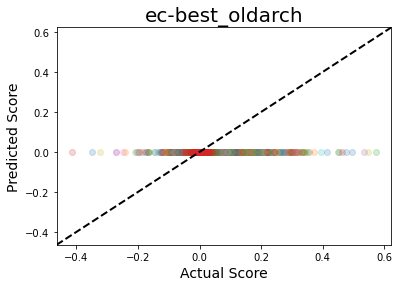

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

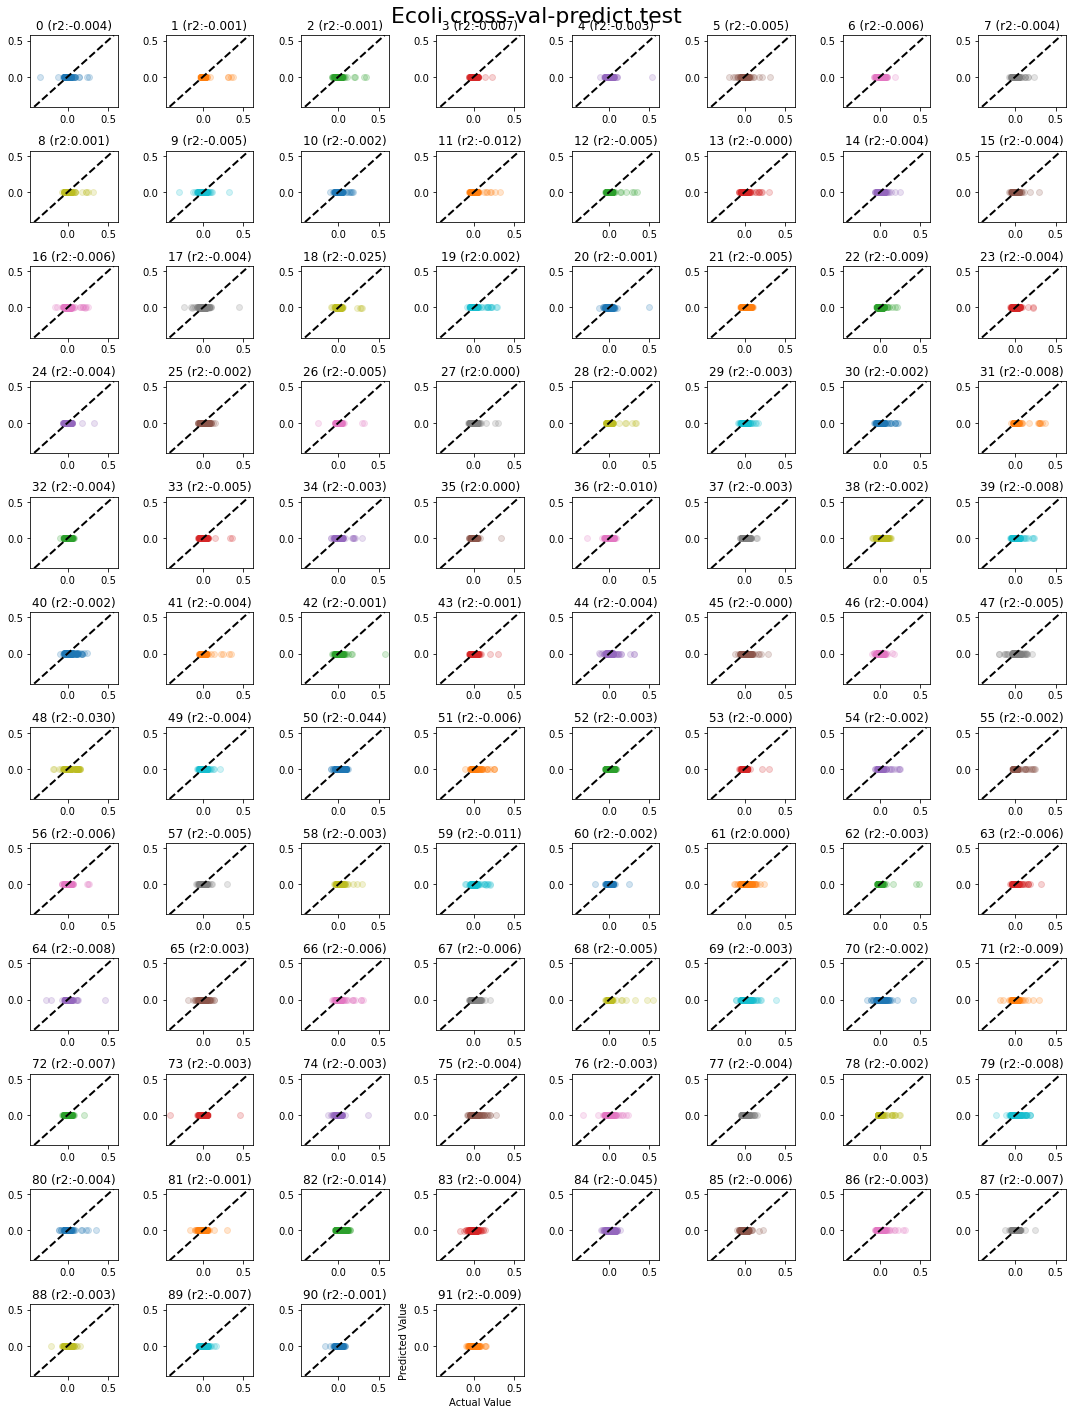

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one